In [2]:
import numpy as np
import matplotlib.pyplot as pl
import os
from os import listdir
import tensorflow as tf

2024-04-04 10:44:32.359958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 10:44:32.911518: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-04 10:44:32.995831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-04 10:44:32.995864: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [3]:
split_frac = 0.7
d_Y = '../data/Y/'
d_X = '../data/X/'

IDs = sorted(listdir(d_Y))
IDs = np.array([I.replace('.npy','') for I in IDs])
IDs_train = np.array(IDs[:int(split_frac*len(IDs))])
IDs_test = np.array(IDs[int(split_frac*len(IDs)):])

IDs_test = np.array([i for i in IDs_test if '042-03' not in i])
IDs_patient_test = np.unique(np.array([i.split('_')[0] for i in IDs_test]))
IDs_patient_train = np.unique(np.array([i.split('_')[0] for i in IDs_train]))

In [4]:
Y_test = []
X_test = []
for i, ID in enumerate(IDs_test):
    Y_test.append(np.load(d_Y+ID+'.npy'))
    X_test.append(np.load(d_X+ID+'.npy'))

        
    
Y_test = np.array(Y_test)
X_test = np.array(X_test)

In [6]:
model = tf.keras.models.load_model('../model/')


2024-04-04 10:44:59.513762: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-04-04 10:44:59.513816: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: astr-campratt-lnx.astro.lsa.umich.edu
2024-04-04 10:44:59.513822: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: astr-campratt-lnx.astro.lsa.umich.edu
2024-04-04 10:44:59.513980: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.239.6
2024-04-04 10:44:59.514000: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.239.6
2024-04-04 10:44:59.514005: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.239.6
2024-04-04 10:44:59.515005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to 

In [7]:
pred = model.predict(X_test)
pred_onehot = np.zeros_like(pred)
pred_onehot[np.arange(len(pred)), pred.argmax(1)] = 1

452/452 [==============================] - 19s 42ms/step


In [21]:
def stats(Y_true,Y_pred, stat='OA',tissue_type=None):
    if Y_true.shape[0]>Y_true.shape[1]:
        Y_true = Y_true.T
    if Y_pred.shape[0]>Y_pred.shape[1]:
        Y_pred = Y_pred.T

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    if tissue_type == None:
        for i in range(len(Y_true)):
            TP += np.where((Y_true[i] == 1) & (Y_pred[i] == 1))[0].size
            TN += np.where((Y_true[i] == 0) & (Y_pred[i] == 0))[0].size
            FP += np.where((Y_true[i] == 0) & (Y_pred[i] == 1))[0].size
            FN += np.where((Y_true[i] == 1) & (Y_pred[i] == 0))[0].size

    if tissue_type=='normal':
        i=0
        TP += np.where((Y_true[i] == 1) & (Y_pred[i] == 1))[0].size
        TN += np.where((Y_true[i] == 0) & (Y_pred[i] == 0))[0].size
        FP += np.where((Y_true[i] == 0) & (Y_pred[i] == 1))[0].size
        FN += np.where((Y_true[i] == 1) & (Y_pred[i] == 0))[0].size

    if tissue_type=='tumor':
        i=1
        TP += np.where((Y_true[i] == 1) & (Y_pred[i] == 1))[0].size
        TN += np.where((Y_true[i] == 0) & (Y_pred[i] == 0))[0].size
        FP += np.where((Y_true[i] == 0) & (Y_pred[i] == 1))[0].size
        FN += np.where((Y_true[i] == 1) & (Y_pred[i] == 0))[0].size

    #print(TP,TN,FP,FN)

    if stat=='OA':
        return (TP+TN)/(TP+TN+FP+FN)
    if stat=='specificity':
        return TN/(TN+FP)
    if stat=='sensitivity':
        return TP/(TP+FN)
    if stat=='precision':
        return TP/(TP+FP)
    if stat=='F1':
        return 2*TP/(2*TP+FP+FN)
    if stat=='accuracy':
        return (TP+TN)/(TP+TN+FP+FN)
    if stat=='recall':
        return TP/(TP+FN)

In [42]:
precisions = []
sensitivities = []
specificities = []
F1s = []
accuracies = []
for i, ID in enumerate(IDs_patient_test):
    w = np.where([ID in j for j in IDs_test])[0]
    
    precisions.append([stats(Y_test[w],pred_onehot[w],stat='sensitivity',tissue_type='normal'),stats(Y_test[w],pred_onehot[w],stat='sensitivity',tissue_type='tumor')])
    sensitivities.append([stats(Y_test[w],pred_onehot[w],stat='specificity',tissue_type='normal'),stats(Y_test[w],pred_onehot[w],stat='specificity',tissue_type='tumor')])
    specificities.append([stats(Y_test[w],pred_onehot[w],stat='precision',tissue_type='normal'),stats(Y_test[w],pred_onehot[w],stat='precision',tissue_type='tumor')])
    F1s.append([stats(Y_test[w],pred_onehot[w],stat='F1',tissue_type='normal'),stats(Y_test[w],pred_onehot[w],stat='F1',tissue_type='tumor')])
    accuracies.append([stats(Y_test[w],pred_onehot[w],stat='accuracy',tissue_type='normal'),stats(Y_test[w],pred_onehot[w],stat='accuracy',tissue_type='tumor')])
    

precisions = np.array(precisions)
sensitivities = np.array(sensitivities)
specificities = np.array(specificities)
F1s = np.array(F1s)
accuracies = np.array(accuracies)

043-01

043-02

050-01

053-01

056-01

056-02

057-01

058-02



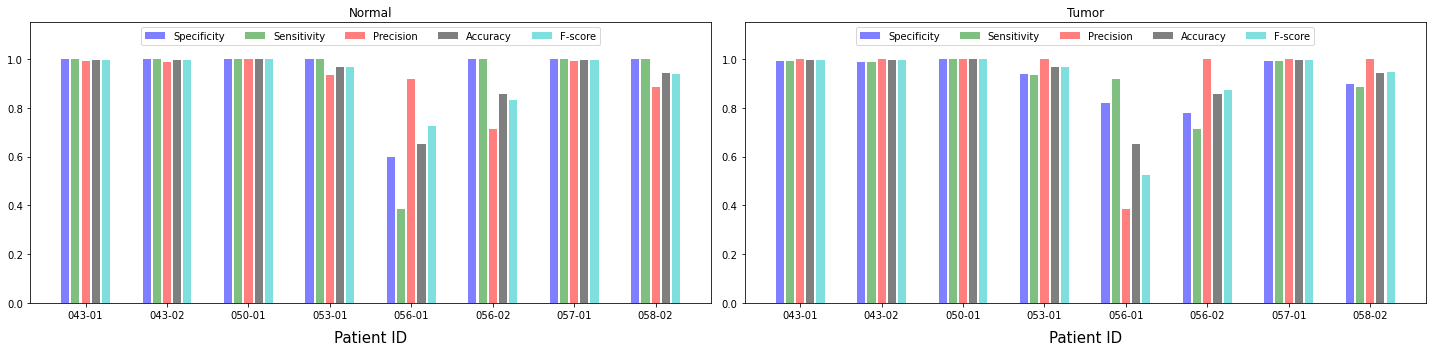

In [57]:
# Plotting
bar_width = 0.2

r = np.arange(0,2*len(IDs_patient_test),2)

fig, ax = pl.subplots(1,2,figsize=(20,5))

offset = 0.25

ax[0].bar(r-(2*offset), specificities.T[0],width=bar_width, color='b', label='Specificity',alpha=0.5)
ax[0].bar(r - offset, sensitivities.T[0], width=bar_width,color='g', label='Sensitivity',alpha=0.5)
ax[0].bar(r, precisions.T[0], width=bar_width, color='r', label='Precision', alpha=0.5)
ax[0].bar(r+offset, accuracies.T[0], width=bar_width, color='k', label='Accuracy', alpha=0.5)
ax[0].bar(r+(2*offset), F1s.T[0], width=bar_width, color='c', label='F-score', alpha=0.5)

ax[1].bar(r-(2*offset), specificities.T[1],width=bar_width, color='b', label='Specificity',alpha=0.5)
ax[1].bar(r - offset, sensitivities.T[1], width=bar_width,color='g', label='Sensitivity',alpha=0.5)
ax[1].bar(r, precisions.T[1], width=bar_width, color='r', label='Precision', alpha=0.5)
ax[1].bar(r+offset, accuracies.T[1], width=bar_width, color='k', label='Accuracy', alpha=0.5)
ax[1].bar(r+(2*offset), F1s.T[1], width=bar_width, color='c', label='F-score', alpha=0.5)


ax[0].set_xticks(r)
ax[0].set_xticklabels(IDs_patient_test)
ax[0].set_title('Normal')
ax[0].legend(ncol=5,loc='upper center')
ax[0].set_ylim(0,1.15)
ax[0].set_xlabel('Patient ID',fontsize=15,color='black',labelpad=10)

ax[1].set_xticks(r)
ax[1].set_xticklabels(IDs_patient_test)
ax[1].set_title('Tumor')
ax[1].legend(ncol=5,loc='upper center')
ax[1].set_ylim(0,1.15)
ax[1].set_xlabel('Patient ID',fontsize=15,color='black',labelpad=10)

pl.tight_layout()

fig.savefig('model_performance.png')